In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
rocket = sns.color_palette("rocket", as_cmap=True)

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150
plt.ioff()

from tqdm.notebook import tqdm
from toric import *
# from mwpm import *

In [3]:
# Simulation parameters

L = 50 # Lattice size
p_error = 0.06 # Error probability per spin
η = 0.5 # Smoothing paramter for Jacobi method
c = 10 # "Field velocity" - number of field updates per cycle
T = 100 # Epochs

In [ ]:
mystate = init_state(L, p_error)
q_history, error_history = decoder_2D(mystate, T, c, η, history = True)
print(mystate.N > 0 or logical_error(mystate.error))
plot_evolution(q_history, error_history, trail = False)

In [6]:
fail_rate = np.zeros((40, 20)) # L/2, c
shots = 10

In [7]:
for c in tqdm(range(20)):
    for L in tqdm(range(0, 80, 2)):
        T = 10 * L
        fails = 0
        for _ in range(shots):
            mystate = init_state(L, p_error)
            decoder_2D(mystate, T, c, η, history = False)
            fails += (mystate.N > 0 or logical_error(mystate.error))
        fail_rate[L // 2, c] = fails / shots

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

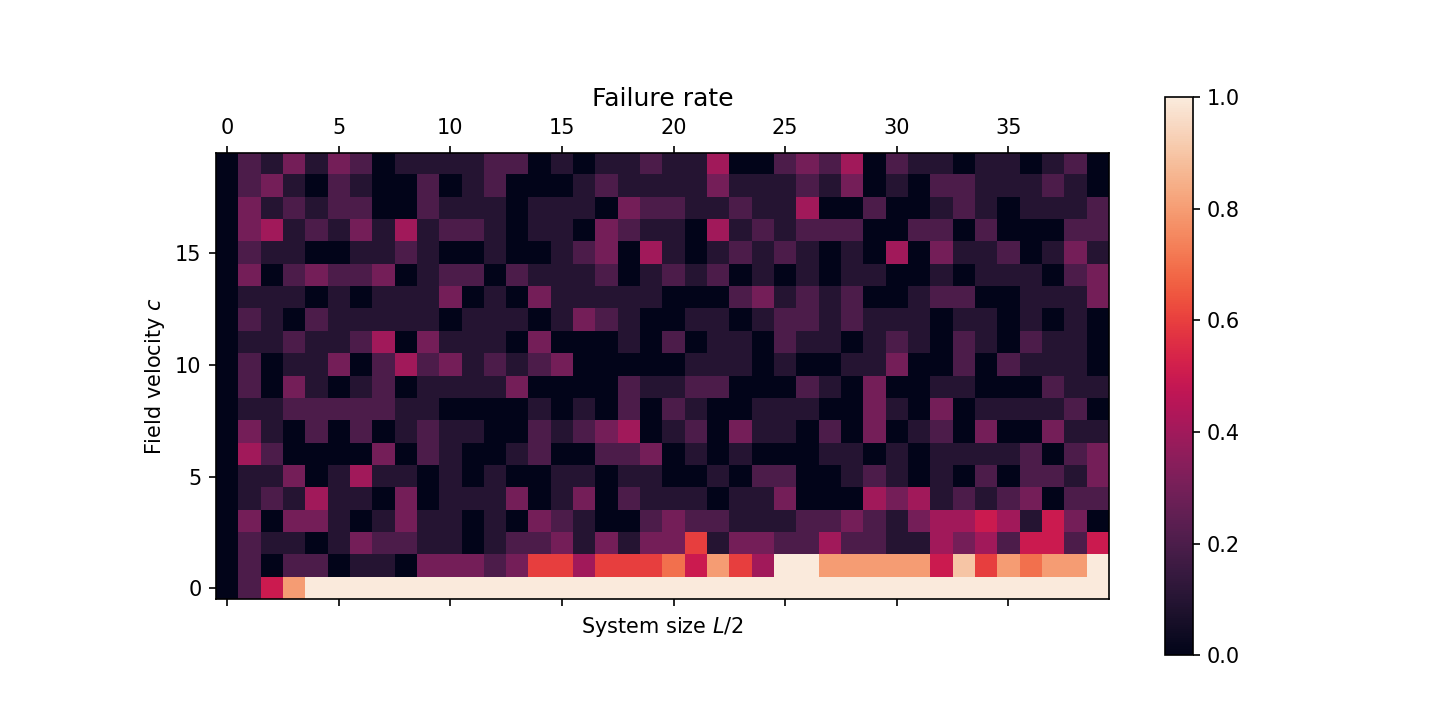

In [9]:

plt.matshow(fail_rate.T, origin = 'lower', cmap = rocket)
plt.colorbar()
plt.xlabel('System size $L/2$')
plt.ylabel('Field velocity $c$')
plt.title('Failure rate')
plt.savefig('fail_rate.png')
plt.show()